In [136]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
env = gym.envs.make("MountainCarContinuous-v0")

In [137]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(ActorCriticModel,self).__init__()
        self.fc = nn.Linear(n_input, n_hidden)
        self.mu = nn.Linear(n_hidden, n_output)
        self.sigma = nn.Linear(n_hidden, n_output)
        self.value = nn.Linear(n_hidden, 1)
        self.distribution = torch.distributions.Normal

    def forward(self, x):
        x = F.relu(self.fc(x))
        mu = 2* torch.tanh(self.mu(x))
        sigma = F.softplus(self.sigma(x)) + 1e-5
        dist = self.distribution(mu.view(1,).data,sigma.view(1,).data)
        value = self.value(x)

        return dist, value

In [138]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr = 0.001):
        self.model = ActorCriticModel(n_state, n_action, n_hidden)
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),lr
        )

    def predict(self, s):
        self.model.training = False
        return self.model(torch.Tensor(s))
    
    def update(self,returns,  log_probs, state_values):
        loss = 0 
        for log_prob, value, Gt in zip (log_probs,state_values, returns):
            advantage = Gt - value.item()
            policy_loss = -log_prob * advantage
           # print("value ",value)
           # print("log prob " ,log_prob)
            #print("Gt " ,Gt)

            value_loss = F.smooth_l1_loss(value,torch.tensor([Gt]))
            loss += policy_loss  + value_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    
    def get_action(self,s):
        dist , state_value = self.predict(s)
        action = dist.sample().numpy()
        log_prob = dist.log_prob(torch.tensor(action[0]))
        return action , log_prob, state_value

In [139]:
import sklearn.preprocessing 
import numpy as np
state_space_samples = np.array(
    [env.observation_space.sample() for x in range(10000)]
)

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(state_space_samples)

StandardScaler()

In [140]:
def scale_state(state):
    scaled = scaler.transform([state])
    return scaled[0]

In [141]:
def actor_critic(env, estimator, n_episode , gamma = 1.0):
    for episode in range(n_episode):
        log_probs = []
        rewards = []
        state_values = []
        is_done = False
        state,_ = env.reset()
        #print(state)
        print("begin")
        i =0 
        while True:
            state = scale_state(state)
            action , log_prob, state_value = estimator.get_action(state)
            
            action = action.clip(env.action_space.low[0], env.action_space.high[0])
            #i += 1
            #print("count : ",i)
            next_state, reward , terminated , truncated , _ = env.step(action)
            #print(reward)
            #print(terminated)
            
            if terminated or truncated:
                #reward = reward + 100
                is_done = True
            
            total_reward_episode[episode] += reward
            #print(reward)
            log_probs.append(log_prob)
            state_values.append(state_value)
            rewards.append(reward)
            if is_done:
                
                returns = []
                Gt = 0
                pw = 0
                for reward in rewards[::-1]:
                    Gt += gamma **pw *reward
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean())/(returns.std() + 1e-9)
               # print("log and state vals", len(log_probs),len(state_values))
                estimator.update(
                    returns, log_probs, state_values
                )
                print('Episode: {}, total reward : {}'.format(episode, total_reward_episode[episode]))
                break 

            state = next_state

            

In [142]:
n_state = env.observation_space.shape[0]
n_action = 1
n_hidden = 150
lr = 0.0003
policy_net = PolicyNetwork(n_state,n_action, n_hidden, lr)
gamma = 0.9

In [143]:
n_episode  = 200
total_reward_episode = [0] * n_episode
actor_critic(env, policy_net, n_episode, gamma)


begin


/home/prayash/.local/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0, total reward : 67.33738668908943
begin
Episode: 1, total reward : 81.49340573002164
begin
Episode: 2, total reward : 77.19869360602462
begin
Episode: 3, total reward : 77.87021500099226
begin
Episode: 4, total reward : 86.58013765206059
begin
Episode: 5, total reward : 77.9578398331885
begin
Episode: 6, total reward : 64.98789221977248
begin
Episode: 7, total reward : 80.80593192847162
begin
Episode: 8, total reward : 74.47684198889453
begin
Episode: 9, total reward : 83.56723450593861
begin
Episode: 10, total reward : 63.31019042067463
begin
Episode: 11, total reward : 79.58881867548463
begin
Episode: 12, total reward : 79.56478948204185
begin
Episode: 13, total reward : 83.05024343539
begin
Episode: 14, total reward : 73.73303630185782
begin
Episode: 15, total reward : 70.62623339876734
begin
Episode: 16, total reward : 84.7436421192518
begin
Episode: 17, total reward : 72.53635221424916
begin
Episode: 18, total reward : 74.44896518618476
begin
Episode: 19, total reward :

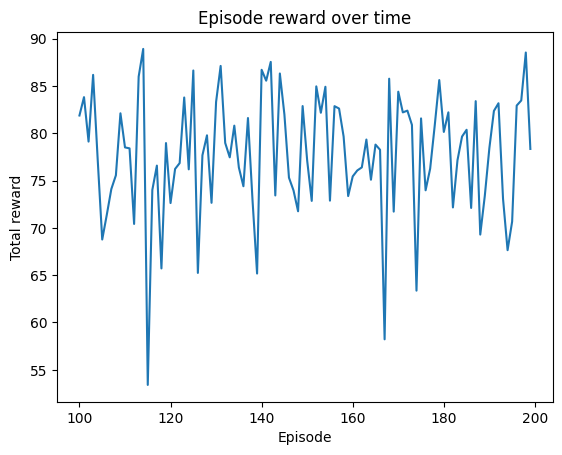

In [144]:
import matplotlib.pyplot as plt
plt.plot(range(100, n_episode), total_reward_episode[100:])
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()
